In [19]:
from ephys_queries import (
    select_spike_times
)
from ephys_queries import db_setup_core
from dotenv import load_dotenv

In [75]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Set2")
plt.rc('legend',fontsize=15)

In [3]:
from spiketimes.df.statistics import ifr_by

In [270]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"
dfb = pd.read_csv(data_dir / "baseline.csv")
dfr = pd.read_csv(data_dir / "rsctest_LC_sizes.csv")

## Positively Correlated Neurons

In [271]:
#find a good session
(
    dfr
    .loc[lambda x: (x.R_spike_count > 0.6) & (x.comb == "sr_sr")]
    .sample(5)
)

,spiketrain_1,spiketrain_2,R_spike_count,p,session_name,min_fr,n_boot,binsize,spiketrain_1_cluster,spiketrain_2_cluster,has_sr,has_sir,has_ff,comb
9090,1866,1884,0.778831,0.0,hamilton_35,0.5,1000,0.2,slow_regular,slow_regular,True,False,False,sr_sr
10080,1884,1904,0.637649,0.0,hamilton_35,0.5,1000,0.2,slow_regular,slow_regular,True,False,False,sr_sr
1658,114,122,0.702616,0.0,ESHOCK_08_LOC1,0.5,1000,0.2,slow_regular,slow_regular,True,False,False,sr_sr
11185,1982,1983,0.645667,0.0,hamilton_32,0.5,1000,1.0,slow_regular,slow_regular,True,False,False,sr_sr
1669,120,122,0.823373,0.0,ESHOCK_08_LOC1,0.5,1000,1.0,slow_regular,slow_regular,True,False,False,sr_sr


In [290]:
candidate_recording = "acute_12"
candidate_1 = 2571
candidate_2 = 2590

In [291]:
load_dotenv()
engine, metadata = db_setup_core()
session_names = [candidate_recording]
block_name = "pre"
fs = 30000

df_spiketimes = (
    select_spike_times(
        engine, metadata, 
        block_name=block_name, 
        session_names=session_names,
    )
    .loc[lambda x: x.neuron_id.isin([candidate_1, candidate_2])]
    .assign(
        spiketimes= lambda x: x["spike_time_samples"].divide(fs)
    )
)

In [292]:
df_spiketimes.head(3)

,neuron_id,spike_time_samples,session_name,spiketimes
179924,2571,586829,acute_12,19.560967
179925,2571,591203,acute_12,19.706767
179926,2571,1392042,acute_12,46.401400


In [293]:
t_start = 100
t_stop = t_start + 10

dfp = ifr_by(df_spiketimes, fs=5, spiketrain_col="neuron_id", sigma=6.5)

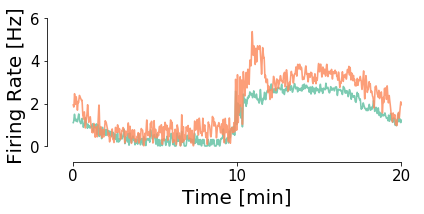

In [294]:
t_start = 2400
t_stop=t_start + 1200

_, ax = plt.subplots(figsize=(6, 3))

ax = (
    dfp
    .assign(neuron_id=lambda x: x.neuron_id.map({candidate_1:"neuron_1", candidate_2: "neuron_2"}))
    .loc[lambda x: (x.time >= t_start) & (x.time <= t_stop)]
    .pipe(lambda x: sns.lineplot(x="time", y="ifr", hue="neuron_id", data=x, alpha=0.85, linewidth=1.6, ax=ax))
)
ax.set_ylabel("Firing Rate [Hz]", fontsize=20)
ax.set_yticks([0, 2, 4, 6])


ax.set_xlabel("Time [min]", fontsize=20)
ax.set_xticks([2400, 3000, 3600])
ax.set_xticklabels([0, 5, 10])

ax.get_legend().remove()
sns.despine(offset=10, trim=True)
ax.set_xticklabels([0, 10, 20], fontsize=15)
ax.set_yticklabels([0, 2, 4, 6], fontsize=15)
plt.tight_layout()
plt.savefig(str(fig_dir / "positively_correlated_example.png"), dpi=300, transparent=True)

## Negatively Correlated

In [282]:
(
    dfr
    .loc[lambda x: (x.R_spike_count < -0.6) & (x.comb == "sr_ff")]
    .sample(5)
)

,spiketrain_1,spiketrain_2,R_spike_count,p,session_name,min_fr,n_boot,binsize,spiketrain_1_cluster,spiketrain_2_cluster,has_sr,has_sir,has_ff,comb
11899,2301,2329,-0.736857,0.0,acute_15,0.5,1000,1.0,slow_regular,fast_firing,True,False,True,sr_ff
12295,2301,2352,-0.818629,0.0,acute_15,0.5,1000,1.0,slow_regular,fast_firing,True,False,True,sr_ff
12293,2299,2352,-0.782375,0.0,acute_15,0.5,1000,1.0,slow_regular,fast_firing,True,False,True,sr_ff
495,31,47,-0.642396,0.0,ESHOCK_04_LOC1,0.5,1000,1.0,fast_firing,slow_regular,True,False,True,sr_ff
3123,145,181,-0.604867,0.0,ESHOCK_09_LOC1,0.5,1000,1.0,slow_regular,fast_firing,True,False,True,sr_ff


In [283]:
candidate_recording = "acute_15"
candidate_1 = 2301
candidate_2 = 2352

In [284]:
load_dotenv()
engine, metadata = db_setup_core()
session_names = [candidate_recording]
block_name = "pre"
fs = 30000

df_spiketimes = (
    select_spike_times(
        engine, metadata, 
        block_name=block_name, 
        session_names=session_names,
    )
    .loc[lambda x: x.neuron_id.isin([candidate_1, candidate_2])]
    .assign(
        spiketimes= lambda x: x["spike_time_samples"].divide(fs)
    )
)

In [285]:
t_start = 100
t_stop = t_start + 10

dfp = ifr_by(df_spiketimes, fs=5, spiketrain_col="neuron_id", sigma=10.5)

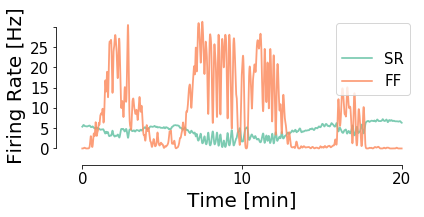

In [289]:
t_start = 1550
t_stop=t_start + 1200

_, ax = plt.subplots(figsize=(6, 3))

ax = (
    dfp
    .assign(neuron_id=lambda x: x.neuron_id.map({candidate_1:"SR", candidate_2: "FF"}))
    .loc[lambda x: (x.time >= t_start) & (x.time <= t_stop)]
    .pipe(lambda x: sns.lineplot(x="time", y="ifr", hue="neuron_id", data=x, alpha=0.85, linewidth=1.8, ax=ax))
)
ax.set_ylabel("Firing Rate [Hz]", fontsize=20)



ax.set_xlabel("Time [min]", fontsize=20)
ax.set_xticks([1550, 2150, 2750])

sns.despine(offset=10, trim=True)
plt.legend(fontsize=15)
legend = ax.legend()
legend.texts[0].set_text("")

ax.set_xticklabels([0, 10, 20], fontsize=15)
ax.set_yticklabels([0, 5, 10, 15, 20, 25], fontsize=15)
plt.tight_layout()
plt.savefig(str(fig_dir / "negatively_correlated_example.png"), dpi=300, transparent=True)